# Agentic RAG From Scratch: Building with LangGraph and Open-Source Models

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives and locally-hosted open-source models.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Ollama to run open-source models locally (gpt-oss:20b + embeddinggemma)
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Breakout Room #1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Ollama Setup
  - Task 2: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 3: Building a ReAct Agent from Scratch
  - Task 4: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Breakout Room #2:** Agentic RAG with Local Models
  - Task 5: Loading & Chunking with LangChain
  - Task 6: Setting up Qdrant with Local Embeddings
  - Task 7: Creating a RAG Tool
  - Task 8: Building Agentic RAG from Scratch
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Breakout Room #1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Ollama Setup

Before we begin, make sure you have:

1. **Ollama installed** - Download from [ollama.com](https://ollama.com/)
2. **Ollama running** - Start with `ollama serve` in a terminal
3. **Models pulled** - Run these commands:

```bash
# Chat model for reasoning and generation (~12GB)
ollama pull gpt-oss:20b

# Embedding model for RAG (~622MB)
ollama pull embeddinggemma
```

> **Note**: If you don't have enough RAM/VRAM for `gpt-oss:20b` (requires 16GB+ VRAM or 24GB+ RAM), you can substitute with `llama3.2:3b` or another smaller model.

**📚 Documentation:**
- [Ollama Installation Guide](https://ollama.com/download)
- [gpt-oss Model Card](https://ollama.com/library/gpt-oss)
- [EmbeddingGemma Model Card](https://ollama.com/library/embeddinggemma)
- [langchain-ollama Integration](https://python.langchain.com/docs/integrations/providers/ollama/)

In [10]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [11]:
# Verify Ollama is running and models are available
from langchain_ollama import ChatOllama, OllamaEmbeddings

# Test connection to Ollama
try:
    test_llm = ChatOllama(model="gpt-oss:20b", temperature=0)
    test_response = test_llm.invoke("Say 'Ollama is working!' in exactly 3 words.")
    print(f"Chat Model Test: {test_response.content}")
    
    test_embeddings = OllamaEmbeddings(model="embeddinggemma")
    test_vector = test_embeddings.embed_query("test")
    print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
    print("\nOllama is ready!")
except Exception as e:
    print(f"Error connecting to Ollama: {e}")
    print("\nMake sure:")
    print("1. Ollama is installed: https://ollama.com/")
    print("2. Ollama is running: 'ollama serve'")
    print("3. Models are pulled: 'ollama pull gpt-oss:20b' and 'ollama pull embeddinggemma'")

Chat Model Test: Ollama is working!
Embedding Model Test: Vector dimension = 768

Ollama is ready!


## Task 2: LangGraph Core Concepts

In Session 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [12]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

# Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


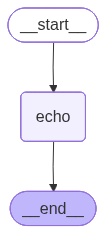

In [13]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [14]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [15]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

AgentState defined with messages field


In [16]:
# Step 2: Initialize our local LLM with Ollama
llm = ChatOllama(
    model="gpt-oss:20b",
    temperature=0,  # Deterministic for reproducibility
)

print(f"LLM initialized: {llm.model}")

LLM initialized: gpt-oss:20b


## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)

In [17]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool list
tools = [calculate, get_current_time]

# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...


In [18]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [19]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [20]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [21]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


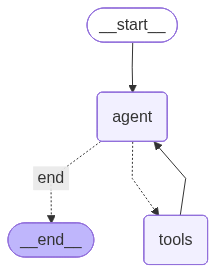

In [22]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [15]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [Tool calls: [{'name': 'calculate', 'args': {'expression': '25 * 48'}, 'id': '3a4f8b74-6acf-4402-99f8-b6984728b260', 'type': 'tool_call'}]]
  [ToolMessage]: The result of 25 * 48 is 1200
  [AIMessage]: 1200


In [16]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:

Final response:
It’s 22:41 (10 p.m.) now.  
100 divided by the current hour (22) is **4.545454545454546**.


In [17]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="Calculate 15% of 200")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 0.15*200 is 30.0

[Node: agent]
  Content: 30.


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:
*In our should_continue func, we decide whether to call a tool or end the execution based solely on the last message in the agent state: if the message contains tool calls, we route to tools else end the agent. In create_agent, it manages tool calling in a loop until the LLM produces a final answer. Also includes additional logic such as loop control, limits, tool validation and error recovery that we did not implement.*

## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:
*ToolNode is an abstract that reads tool calls from the agent state, matches them to registered tools, executes them and writes the results back to the state. Because it is prebuilt, we have limited control over the execution lifecycle and rely on default behaviour for failures and retries. While we can add logging before or after the node runs, we cannot easily log per tool call details. Error handling is generic and there is no built-in support for rate limiting. 

Building a custom tool node gives full control over logging, error handling, retries, rate limited and how tool results are represented within the agent graph.*

---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

In [17]:
### YOUR CODE HERE ###

# Example: Add iteration tracking to prevent infinite loops
class AgentStateWithCounter(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    iteration_count: int
    max_iterations: int

def custom_should_continue(state: AgentStateWithCounter) -> Literal["tools", "end"]:
    """Custom routing with iteration limit."""
    # Stop if max iterations reached 
    if state["iteration_count"] >= state["max_iterations"]:
        return "end"

    last_message = state["messages"][-1]

    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Max iteration limit defined")

def thinking_node(state: AgentStateWithCounter) -> AgentStateWithCounter:
    """Add a small 'thinking' message before tool execution."""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        tool_name = last_message.tool_calls[0]["name"]
        state["messages"].append(
            AIMessage(content=f"Thinking before calling tool `{tool_name}`...")
        )
    return state

print("New thinking node defined")


Max iteration limit defined
New thinking node defined


In [20]:
# Step 7: Build the Graph!
workflow_2 = StateGraph(AgentStateWithCounter)

# Add nodes
workflow_2.add_node("agent", agent_node)
workflow_2.add_node("thinking", thinking_node)
workflow_2.add_node("tools", tool_node)

# Set the entry point
workflow_2.add_edge(START, "agent")

# Add conditional edge from agent
workflow_2.add_conditional_edges(
    "agent",
    custom_should_continue,
    {
        "tools": "thinking",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

#Add edge routes to tools
workflow_2.add_edge("thinking", "tools")

# Add edge from tools back to agent (the loop!)
workflow_2.add_edge("tools", "agent")

# Compile the graph
custom_agent = workflow_2.compile()

print("Custom agent with iteration limit and thinking node built!")


Custom agent with iteration limit and thinking node built!


In [21]:

print("Testing my custom agent:")
print("=" * 50)

response = custom_agent.invoke({
    "messages": [HumanMessage(content="What is 25 * 48?")],
    "iteration_count": 0,
    "max_iterations": 5

})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing my custom agent:

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [Tool calls: [{'name': 'calculate', 'args': {'expression': '25 * 48'}, 'id': 'b3a7a7eb-fa4b-428d-9173-6b457566ff4b', 'type': 'tool_call'}]]
  [AIMessage]: Thinking before calling tool `calculate`...
  [AIMessage]: commentary<|message|>The result is 1200.1200


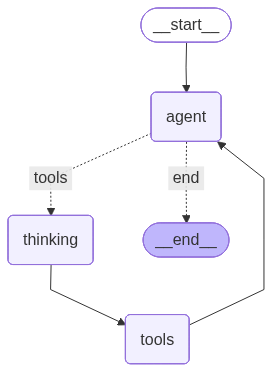

In [22]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(custom_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(custom_agent.get_graph().draw_ascii())

---
# Breakout Room #2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using our local models!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `TextFileLoader` | `TextLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `OllamaEmbeddings` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [TextLoader Reference](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.text.TextLoader.html)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [23]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the document using LangChain's TextLoader
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nDocument metadata: {documents[0].metadata}")

Loaded 1 document(s)
Total characters: 16,206

Document metadata: {'source': 'data/HealthWellnessGuide.txt'}


In [24]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 45 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 6: Setting up Qdrant with Local Embeddings

Now we'll use **OllamaEmbeddings** with the `embeddinggemma` model - completely local!

**📚 Documentation:**
- [OllamaEmbeddings Reference](https://python.langchain.com/api_reference/ollama/embeddings/langchain_ollama.embeddings.OllamaEmbeddings.html)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)
- [EmbeddingGemma Overview (Google)](https://ai.google.dev/gemma/docs/embeddinggemma)

In [25]:
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize local embedding model
embedding_model = OllamaEmbeddings(model="embeddinggemma")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")
print(f"Using local model: embeddinggemma")

Embedding dimension: 768
Using local model: embeddinggemma


In [26]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base_local"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base_local


In [27]:
# Create vector store and add documents
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
print("Adding documents to vector store (this may take a moment with local embeddings)...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} documents to vector store")

Adding documents to vector store (this may take a moment with local embeddings)...
Added 45 documents to vector store


In [28]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consistent sleep schedule, eve...

--- Document 2 ---
Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit (18-20 Celsius)
- Darkness: Use blackout curtains or a sleep mask
- Quiet: Consider white noise machines or earplugs
- Co...

--- Document 3 ---
Types of insomnia:
- Acute insomnia: Short-term, often triggered by stress or life events
- Chronic insomnia: Long-term, occurring at least 3 nights per week for 3 months or more

Natural remedies for...


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use.

In [29]:
@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_wellness_knowledge.name}")

RAG tool created: search_wellness_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch!

In [30]:
# Define all tools for our RAG agent
rag_tools = [search_wellness_knowledge, calculate, get_current_time]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_wellness_knowledge
  - calculate
  - get_current_time


In [31]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. ALWAYS search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with wellness system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [33]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch!")

Agentic RAG built from scratch!


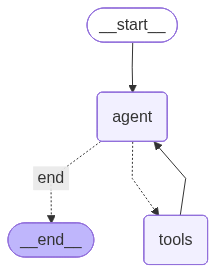

In [34]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [34]:
# Test the RAG agent
print("Testing Agentic RAG (with local models):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What are some tips for better sleep?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with local models):

Final Response:
Here are some evidence‑based tips that can help you fall asleep faster, stay asleep longer, and wake up feeling refreshed:

| Tip | Why it works | How to implement it |
|-----|--------------|---------------------|
| **Keep a consistent sleep schedule** | Your body’s internal clock (circadian rhythm) thrives on routine. | Go to bed and wake up at the same time every day—even on weekends. |
| **Create a calming pre‑bed routine** | Activities that lower heart rate and relax the mind signal your body that it’s time to wind down. | Read a book, do gentle stretching, or take a warm bath 30–60 min before bed. |
| **Optimize your bedroom environment** | Light, noise, temperature, and comfort all influence sleep quality. | • Keep the room **cool** (65–68 °F / 18–20 °C). <br>• Make it **dark** with blackout curtains or a sleep mask. <br>• Reduce noise with a white‑noise machine or earplugs. <br>• Use a supportive mattress and pillows. |
|

In [30]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="I'm stressed and sleeping poorly. What should I do? Also, if I sleep 6 hours a night for a week, how many total hours is that?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
I’m sorry you’re feeling so stressed and having trouble sleeping. Below are some evidence‑based strategies that can help you calm your mind, improve sleep quality, and manage stress. I’ve pulled these from the wellness knowledge base to give you the most reliable guidance.

---

## 1. Quick‑Start Stress‑Reduction Techniques

| Technique | How it Helps | Practical Tips |
|-----------|--------------|----------------|
| **Deep‑breathing / diaphragmatic breathing** | Activates the parasympathetic nervous system, lowering heart rate and cortisol. | 4‑7‑8 method: inhale 4 s, hold 7 s, exhale 8 s. Do 3–5 cycles before bed. |
| **Progressive muscle relaxation** | Releases muscle tension that often builds up with stress. | Tense each muscle group for 5 s, then release for 15 s. Work from toes to head. |
| **Mindfulness or guided imagery** | Shifts focus away from racing thoughts. | Use a 5‑minute guided meditation app (e.g., Insight Timer, Calm). |
|

In [31]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
125 × 8 = **1,000**.


---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Session 3. What are the trade-offs between control and convenience? When would you choose one approach over the other?

##### Answer:
*Building an agent from stratch with LangGraph is more flexible and offers full control, customization of routing, tool execution and memory. create_agent is convenient and production-ready. It handles loops, tool calls automatically. 

Trade-off: Choosing from scratch is handy when require control and customization if project need experimentation, deal with sensitive data or complex logic. Whereas choosing create_agent is good where speed and simplicity is priority for maintainable, production-ready deployments.*

## ❓ Question #4:

We used local models (gpt-oss:20b and embeddinggemma) instead of cloud APIs. What are the advantages and disadvantages of this approach? 

##### Answer:
*Advantages: Data privacy, security, cost savings, fully offline on local, customizable.

Disadvantages: Resource requirements, very slow, maintenance, not scalable/production-ready.*

---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [36]:
### YOUR CODE HERE ###

from langgraph.checkpoint.memory import MemorySaver

# Create a memory saver
memory = MemorySaver()

# Recompile the agent with checkpointing
rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

conversation_messages = [HumanMessage(content="What are some tips for better sleep cycle?")]

response1 = rag_agent_with_memory.invoke(
    input={"messages": conversation_messages},
    config={"configurable": {"thread_id": "conversation-1"}}
)

print("First response:")
print(response1["messages"][-1].content)

follow_up_messages = [HumanMessage(content="How can I improve my sleep schedule?")]

response2 = rag_agent_with_memory.invoke(
    input={"messages": follow_up_messages},
    config={"configurable": {"thread_id": "conversation-1"}}
)

print("\nFollow-up response:")
print(response2["messages"][-1].content)

First response:
Here are some evidence‑based tips that can help you get a smoother, more restorative sleep cycle:

| Tip | Why it works | How to implement it |
|-----|---------------|---------------------|
| **Keep a consistent sleep schedule** | Your body’s internal clock (circadian rhythm) thrives on routine. Even on weekends, aim to go to bed and wake up at the same time. | Set an alarm for bedtime and wake‑up time. If you can’t sleep, get up and do a quiet activity instead of staying in bed. |
| **Create a calming pre‑sleep routine** | Activities that relax the mind and body signal to your brain that it’s time to wind down. | Read a book, do gentle stretches, or take a warm bath 30–60 min before bed. Avoid stimulating activities. |
| **Optimize your bedroom environment** | Light, noise, temperature, and comfort all influence sleep quality. | • **Temperature**: 65–68 °F (18–20 °C). <br>• **Darkness**: Use blackout curtains or a sleep mask. <br>• **Quiet**: Consider a white‑noise mac

---
## Summary

In this session, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used local open-source models** with Ollama (gpt-oss:20b + embeddinggemma)
3. **Transitioned to LangChain** for document loading and text splitting
4. **Created an Agentic RAG system** that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Local models** provide privacy and cost savings, with trade-offs in performance
- **LangSmith** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns
- Build multi-agent systems
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)